# LULC Maps of Mumbai: Classification and Georeferencing
By Harsh Vardhan Pachisia

Jan 2024

## PDF to TIFF Images

In [ ]:

from pdf2image import convert_from_path


#convert to dropbox equivalent
pdf_path = '/Users/Harsh/Desktop/01_Projects/Mumbai_Flooding/lulc_maps.pdf'
#convert to dropbox equivalent
output_folder = '/Users/Harsh/Desktop/01_Projects/Mumbai_Flooding/'

# Convert PDF to a list of images
images = convert_from_path(pdf_path, dpi=600)

years = [1972, 1977, 1991, 1998, 1999, 2000, 2001, 2002, 2003, 2005, 2009, 2011,
         2013, '2014_1', '2014_2', 2015]

# Save each image as a TIFF
for i, image in enumerate(images):
    filename = f'lulc_map_{years[i]}.tiff'
    image.save(f'{output_folder}{filename}', 'TIFF')

KeyboardInterrupt: 

### Big picture steps:
1. Georeference the original image in QGIS
2. Classify the image of a map of land use in Mumbai (different colors with different land use)
3. Store that classification as a tif, define the boundaries
4. Import the classification data (classified image which has the geographical boundaries of Mumbai) onto QGIS
5. Import other data layers like Mumbai pincodes in QGIS
6. Do analysis of differences in pincodes.

### Image Georeferencing
For georeferencing the image (which means assigning real-world coordinates to the image), this generally involves:

1. Having control points that tie image pixel coordinates to geographic coordinates (latitude and longitude, for example).
2. Using these points to define a spatial reference system and transformation parameters.
3. Applying these parameters to the image to create a georeferenced image, typically saved as a GeoTIFF.
(overlay Mumbai GeoTiff?)

## Image Classification

To classify the colors as per the legend, I need to:

1. Read the image into an array where each pixel's color is represented by an RGB tuple.
2. Define a mapping from each color in the legend to a specific class.
3. Replace each pixel's RGB value in the array with the class it corresponds to, according to the mapping.

#### Steps to Classify Colors Based on a Legend:
1. Load the Image: Read the TIFF image into a format that allows access individual pixel colors.

2. Define the Color Legend: Define a mapping from the colors in the legend to their respective classes. Possible dictionary where keys are color tuples (in RGB format) and values are the corresponding class names or identifiers.

3. Process Each Pixel: Iterate over each pixel in the image and replace its color with the corresponding class identifier based on legend mapping.

4. Handling Ambiguity: Exact color matches will be rare due to variations in shading, lighting, or image quality. Need a method to handle colors that don't exactly match your legend colors, like finding the nearest color in your legend.

In [86]:
# manually do this based on  https://www.rapidtables.com/web/color/RGB_Color.html#color-picker
legend_colors = {
    # adding a background for the legend- to be removed later
    (255, 255, 255): 'Background',
    (227, 0, 5): 'Built up land',
    (13, 114, 78): 'Forest plantation',
    (2, 255, 198): 'Mangrove',
    (86, 255, 7): 'Vegetation',
    (255, 255, 5): 'Crop land/Grass land',
    (255, 254, 190): 'Fallow land',
    (209, 253, 123): 'Aquatic vegetation',
    (132, 1, 170): 'Marshy/Swampy land',
    (191, 255, 231): 'Mudflats',
    (200, 200, 200): 'Sandy Area',
    (252, 116, 223): 'Barren Land',
    (0, 77, 170): 'Waterbodies',
    (119, 0, 77): 'Others (Salt pans)'
}

In [87]:
import cv2
import numpy as np

In [88]:
# paper sample years first:2005, 2009, 2011, 2013, 2014, 2015. Do rest later
# should loop this- to do for later
geo_image_path = "/Users/Harsh/Desktop/01_Projects/Mumbai_Flooding/lulc/georeferenced_maps/2014_geocoded.tif"#georeferenced image
output_path = '/Users/Harsh/Desktop/01_Projects/Mumbai_Flooding/lulc/final_maps/lulc_2014.tif' #output path for classified, georeferenced map

In [89]:
# Load the georeferenced image
import rasterio

with rasterio.open(geo_image_path) as src:
    image = src.read()
    # Pixel sizes in the x and y dimensions
    pixel_size_x, pixel_size_y = src.res[0], src.res[1]
    # Upper left coordinates
    upper_left_x, upper_left_y = src.transform * (0, 0)

    # Upper right coordinates
    upper_right_x, upper_right_y = src.transform * (src.width, 0)
    crs = src.crs

#getting this is important for later when saving it back as gecoded
print("Upper Left Coordinates: (", upper_left_x, ",", upper_left_y, ")")
print("Upper Right Coordinates: (", upper_right_x, ",", upper_right_y, ")")
print(crs)
print("Pixel Size (X):", pixel_size_x)
print("Pixel Size (Y):", pixel_size_y)

Upper Left Coordinates: ( 8099821.521620621 , 2193343.978729313 )
Upper Right Coordinates: ( 8127239.581265549 , 2193343.978729313 )
EPSG:3857
Pixel Size (X): 12.169578182391641
Pixel Size (Y): 12.169578182391641


In [90]:
# Reorganize the image data to (height, width, channels)
# first three bands are RGB
rgb_image = np.dstack((image[0], image[1], image[2]))
rgb_image.shape
rgb_image.shape[0]

4417

In [91]:
# function to classify pixels
def classify_pixels(pixels, legend_colors, tolerance=20):
    classified_pixels = np.empty(pixels.shape[:2], dtype=object)
    match_counts = {}
    for color, classification in legend_colors.items():
        lower_bound = np.array(color) - tolerance
        upper_bound = np.array(color) + tolerance
        mask = np.all(np.logical_and(pixels >= lower_bound, pixels <= upper_bound), axis=-1)
        match_counts[classification] = np.sum(mask)
        print(f"Color: {color}, Classification: {classification}, Matches: {np.sum(mask)}")  # Debug print

        classified_pixels[mask] = classification

    return classified_pixels, match_counts

classified_pixels, match_counts = classify_pixels(rgb_image, legend_colors, tolerance=20)

Color: (255, 255, 255), Classification: Background, Matches: 3745301
Color: (227, 0, 5), Classification: Built up land, Matches: 1607946
Color: (13, 114, 78), Classification: Forest plantation, Matches: 207707
Color: (2, 255, 198), Classification: Mangrove, Matches: 260826
Color: (86, 255, 7), Classification: Vegetation, Matches: 28197
Color: (255, 255, 5), Classification: Crop land/Grass land, Matches: 15470
Color: (255, 254, 190), Classification: Fallow land, Matches: 26171
Color: (209, 253, 123), Classification: Aquatic vegetation, Matches: 1413
Color: (132, 1, 170), Classification: Marshy/Swampy land, Matches: 25427
Color: (191, 255, 231), Classification: Mudflats, Matches: 94709
Color: (200, 200, 200), Classification: Sandy Area, Matches: 19464
Color: (252, 116, 223), Classification: Barren Land, Matches: 91692
Color: (0, 77, 170), Classification: Waterbodies, Matches: 1008045
Color: (119, 0, 77), Classification: Others (Salt pans), Matches: 83892


In [92]:
# creating a color map for mapping the categories and pixels
color_map ={
 'Built up land': (255, 0, 0),
 'Crop land/Grass land': (255,255,0),
 'Fallow land': (255, 254, 190),
 'Vegetation': (0,255,0),
 'Forest plantation': (0,100,0),
 'Mangrove': (0,255,255),
 'Aquatic vegetation': (50,205,50),
 'Marshy/Swampy land': (128,0,128),
 'Mudflats': (173,216,230),
 'Sandy Area': (255,250,240),
 'Barren Land': (255,192,203),
 'Waterbodies': (0,0,128),
 'Others (Salt pans)': (119, 0, 77),
 'Background': (250,250,250)
}

In [93]:
# Initialize an empty image with the same dimensions as the original
visualized_image = np.zeros((*classified_pixels.shape, 3), dtype=np.uint8)

# Assign the color to each pixel based on its classification
for classification, color in color_map.items():
    mask = (classified_pixels == classification)
    visualized_image[mask] = color

print(visualized_image)

[[[250 250 250]
  [250 250 250]
  [250 250 250]
  ...
  [250 250 250]
  [250 250 250]
  [250 250 250]]

 [[250 250 250]
  [250 250 250]
  [250 250 250]
  ...
  [250 250 250]
  [250 250 250]
  [250 250 250]]

 [[250 250 250]
  [250 250 250]
  [250 250 250]
  ...
  [250 250 250]
  [250 250 250]
  [250 250 250]]

 ...

 [[250 250 250]
  [250 250 250]
  [250 250 250]
  ...
  [250 250 250]
  [250 250 250]
  [250 250 250]]

 [[250 250 250]
  [250 250 250]
  [250 250 250]
  ...
  [250 250 250]
  [250 250 250]
  [250 250 250]]

 [[250 250 250]
  [250 250 250]
  [250 250 250]
  ...
  [250 250 250]
  [250 250 250]
  [250 250 250]]]


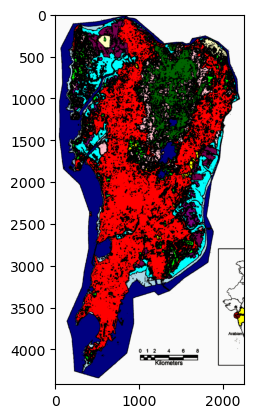

In [94]:
# check to see if image is correct
import matplotlib.pyplot as plt

plt.imshow(visualized_image)
plt.show()

Add a mapping to classification labels for georefernced images

In [95]:
# Create a mapping from classification labels to unique integers
unique_classes = np.unique(classified_pixels[classified_pixels != None])
class_to_id_map = {cls: i for i, cls in enumerate(unique_classes, start=1)}  # Start from 1
class_to_id_map[None] = 0  # Assign 0 to None values
class_to_id_map
# Convert classified_pixels to a numeric format
numeric_classified_pixels = np.vectorize(class_to_id_map.get)(classified_pixels)#.astype(np.int32)

In [96]:
class_to_id_map

{'Aquatic vegetation': 1,
 'Background': 2,
 'Barren Land': 3,
 'Built up land': 4,
 'Crop land/Grass land': 5,
 'Fallow land': 6,
 'Forest plantation': 7,
 'Mangrove': 8,
 'Marshy/Swampy land': 9,
 'Mudflats': 10,
 'Others (Salt pans)': 11,
 'Sandy Area': 12,
 'Vegetation': 13,
 'Waterbodies': 14,
 None: 0}

In [97]:
print("Min value:", numeric_classified_pixels.min())
print("Max value:", numeric_classified_pixels.max())
# convert to int8 since QGIS wont take int64
numeric_classified_pixels = numeric_classified_pixels.astype(np.uint8)

Min value: 0
Max value: 14


In [98]:
np.unique(numeric_classified_pixels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
      dtype=uint8)

In [99]:
from rasterio.transform import from_origin
transform = from_origin(upper_left_x, upper_left_y, pixel_size_x, pixel_size_y)


with rasterio.open(
    output_path, 'w', driver='GTiff',
    height=numeric_classified_pixels.shape[0], width=numeric_classified_pixels.shape[1],
    count=1, dtype=numeric_classified_pixels.dtype,
    crs=crs, transform=transform
) as dst:
    dst.write(numeric_classified_pixels, 1)

### Imported into QGIS
Steps to take:
1. Load OSM boundaries and zoom into Mumbai
2. After importing georeferenced and classified image, apply style in properties.
3. Blur out background. 

In [100]:
# loop over all years to get it for all

### Notes and old code

Converting to georeferenced points in python itself with a bounding box, issues of accuracy.

Better to simply georereference in QGIS itself.